In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def show_rgb(title, img_bgr):
    img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)
    plt.figure()
    plt.title(title)
    plt.axis("off")
    plt.imshow(img_rgb)

In [4]:
def main(img1_path, img2_path):
    img1 = cv.imread(img1_path)
    img2 = cv.imread(img2_path)
    if img1 is None or img2 is None:
        raise FileNotFoundError("Could not read one of the images. Check file paths.")

    gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
    gray2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

    # 1) ORB detect + describe
    orb = cv.ORB_create(
        nfeatures=2000,      # increase for harder scenes
        scaleFactor=1.2,
        nlevels=8)
    
    kp1, des1 = orb.detectAndCompute(gray1, None)
    kp2, des2 = orb.detectAndCompute(gray2, None)

    if des1 is None or des2 is None:
        raise RuntimeError("No descriptors found. Try more texture, higher nfeatures, or better lighting.")

    # 2) Match descriptors (Hamming for ORB)
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=False)

    # KNN matches + Lowe-style ratio test (helps reduce ambiguous matches)
    knn = bf.knnMatch(des1, des2, k=2)
    good = []
    ratio = 0.75
    for m, n in knn:
        if m.distance < ratio * n.distance:
            good.append(m)

    if len(good) < 8:
        raise RuntimeError(f"Too few good matches ({len(good)}). Try different images or relax ratio.")

    # 3) Estimate homography with RANSAC
    pts1 = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    H, inlier_mask = cv.findHomography(
        pts1, pts2,
        method=cv2.RANSAC,
        ransacReprojThreshold=3.0)  # pixels; tune 2-5 typically
    

    if H is None:
        raise RuntimeError("Homography estimation failed. Scene may be non-planar or matches are poor.")

    inliers = int(inlier_mask.sum())
    print(f"Good matches: {len(good)}, Inliers after RANSAC: {inliers}")

    # 4) Visualize matches (inliers vs outliers)
    matches_vis = cv.drawMatches(
        img1, kp1, img2, kp2, good, None,
        matchesMask=inlier_mask.ravel().tolist(),
        flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS    )

    # 5) Warp image1 into image2 coordinates
    h2, w2 = img2.shape[:2]
    warped = cv.warpPerspective(img1, H, (w2, h2))

    # 6) Draw projected quadrilateral of img1 onto img2 (where img1 lands in img2)
    h1, w1 = img1.shape[:2]
    corners1 = np.float32([[0, 0], [w1, 0], [w1, h1], [0, h1]]).reshape(-1, 1, 2)
    corners2 = cv2.perspectiveTransform(corners1, H)
    img2_poly = img2.copy()
    cv.polylines(img2_poly, [np.int32(corners2)], True, (0, 255, 0), 3)

    # Show results
    show_rgb("Image 1", img1)
    show_rgb("Image 2", img2)
    show_rgb("Matches (RANSAC inliers)", matches_vis)
    show_rgb("Image 2 with projected Image 1 corners", img2_poly)
    show_rgb("Warped Image 1 into Image 2 frame", warped)

    plt.show()

Good matches: 91, Inliers after RANSAC: 60


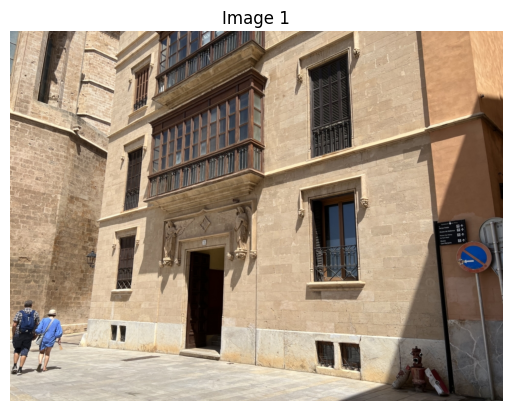

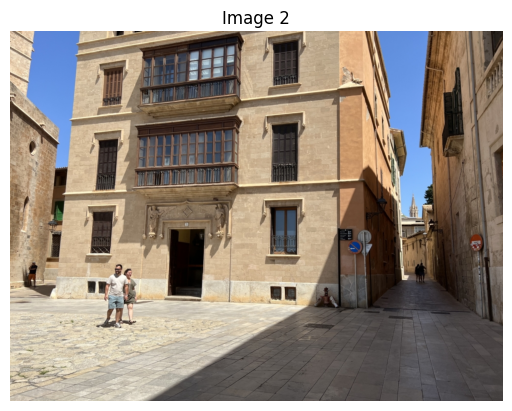

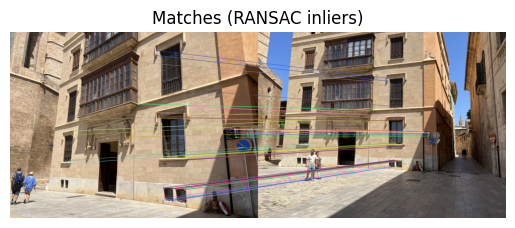

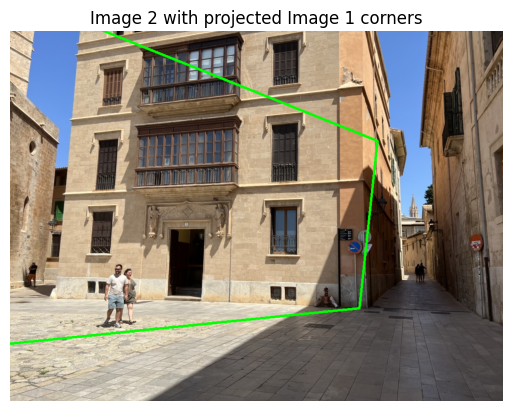

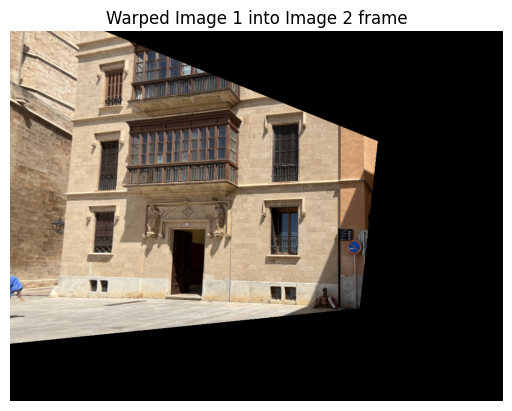

In [8]:
image_1 = r'D:\Python things\middle-ml-cv-roadmap\data\raw\img_example_10.jpeg'
image_2 = r'D:\Python things\middle-ml-cv-roadmap\data\raw\img_example_9.jpeg'
main(image_1, image_2)